In [4]:
from os import listdir
import pandas as pd


In [5]:
a_traincsv = listdir('training/')
b_traincsv = listdir('training_setB/')


with open("train.psv","wb") as fout:

  for i,csv in enumerate(a_traincsv):
    
      # first file:
    if i == 0:
      with open('training/' + csv, "rb") as f:
          fout.write(f.read())
      # now the rest:    
    with open('training/' + csv, "rb") as f:
      next(f) # skip the header
      fout.write(f.read())
      
  for i,csv in enumerate(b_traincsv):
    if i <10000:
      with open('training_setB/' + csv, "rb") as f:
        next(f) # skip the header
        fout.write(f.read())

In [6]:
train = pd.read_csv('train.psv', sep ='|')
train.shape

(1168686, 41)

In [7]:
with open("validation.psv","wb") as fout:

  for i,csv in enumerate(b_traincsv):
    
    if i >=10000 and i <15000:

        # first file:
      if i == 10000:
        with open('training_setB/' + csv, "rb") as f:
            fout.write(f.read())
        # now the rest:    
      with open('training_setB/' + csv, "rb") as f:
        next(f) # skip the header
        fout.write(f.read())

In [8]:
validation = pd.read_csv('validation.psv', sep ='|')
validation.shape

(193026, 41)

In [9]:
with open("test.psv","wb") as fout:

  for i,csv in enumerate(b_traincsv):
    
    if i >=15000:

        # first file:
      if i == 15000:
        with open('training_setB/' + csv, "rb") as f:
            fout.write(f.read())
        # now the rest:    
      with open('training_setB/' + csv, "rb") as f:
        next(f) # skip the header
        fout.write(f.read())

In [10]:
test = pd.read_csv('test.psv', sep ='|')
test.shape

(190615, 41)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
average_precision_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import lightgbm as lgb
import seaborn as sns
from subprocess import call

import warnings
warnings.filterwarnings('ignore')

In [2]:
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),
            'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),
            'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),
            'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),
            'custom_hr'] = 'abnormal'
    train['custom_hr'].fillna('Missing', inplace=True)
    return train

In [3]:
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 
            'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 
            'custom_temp'] = 'abnormal'

    train['custom_temp'].fillna('Missing', inplace=True)
    return train

In [4]:
def featuer_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <1, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=1) & (train['Age'] <65), 
            'custom_age'] = 'child/adult'
    return train

In [5]:
def feature_engineer_o2stat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 
            'custom_o2stat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 
            'custom_o2stat'] = 'abnormal'

    train['custom_o2stat'].fillna('Missing', inplace=True)
    return train

In [6]:
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'

    train.loc[(train['SBP'].between(90,120, inclusive=True)) & 
            (train['DBP'].between(60,80, inclusive=True)), 
            'custom_bp'] = 'normal'


    train.loc[(train['SBP'].between(120,140, inclusive=True)) & 
            (train['DBP'].between(80,90, inclusive=True)), 
            'custom_bp'] = 'elevated'


    train.loc[(train['SBP'] > 140 ) & 
            (train['DBP'] > 90 ), 'custom_bp'] = 'high'

    train['custom_bp'].fillna('Missing', inplace=True)
    return train

In [7]:
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & 
             (train['Age'] <1) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & 
             (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & 
             (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & 
             (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),
            'custom_resp'] = 'abnormal'

    train['custom_resp'].fillna('Missing', inplace=True)


    return train
  

In [9]:
train = pd.read_csv('train.psv', sep = "|")
val = pd.read_csv('validation.psv', sep = '|')

train = featuer_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2stat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)



val = featuer_engineer_age(val)
val = feature_engineer_blood_pressure(val)
val = feature_engineer_hr(val)
val = feature_engineer_o2stat(val)
val = feature_engineer_temp(val)
val = feature_engineer_resp_rate(val)


In [10]:
filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train  = train[filtered_columns]
y_train = train['SepsisLabel']

X_val  = val[filtered_columns]
y_val = val['SepsisLabel']

In [11]:
categorical = X_train.dtypes == object

categorical['Gender'] = True

In [12]:
X_train 

,Gender,custom_hr,custom_temp,custom_age,custom_o2stat,custom_bp,custom_resp,ICULOS,HospAdmTime
0,0,Missing,Missing,old,Missing,Missing,Missing,1,-0.03
1,0,normal,Missing,old,normal,Missing,normal,2,-0.03
2,0,normal,Missing,old,normal,Missing,abnormal,3,-0.03
3,0,normal,Missing,old,normal,Missing,abnormal,4,-0.03
4,0,abnormal,Missing,old,abnormal,Missing,abnormal,5,-0.03
...,...,...,...,...,...,...,...,...,...
1168681,0,normal,Missing,child/adult,normal,Missing,normal,46,-5.07
1168682,0,normal,Missing,child/adult,normal,Missing,Missing,47,-5.07
1168683,0,normal,Missing,child/adult,normal,Missing,normal,48,-5.07
1168684,0,normal,Missing,child/adult,normal,Missing,normal,49,-5.07


In [13]:
y_train 

0          0
1          0
2          0
3          0
4          0
          ..
1168681    0
1168682    0
1168683    0
1168684    0
1168685    0
Name: SepsisLabel, Length: 1168686, dtype: int64

In [17]:
y_train[y_train==1].count()

22337

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
cat_pipeline = make_pipeline( OneHotEncoder(handle_unknown="ignore"))
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                                    StandardScaler())

preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))

In [20]:
def score_model(model, metric_list, y_true, y_pred):
    metric_dict = {'precision' :  precision_score, 'recall' : recall_score, 
                 'confusion_matrix' : confusion_matrix, 
                 'avg_precision': average_precision_score}
    df = pd.DataFrame()
    df['model'] = [model]
    for metric in metric_list:
        df[metric] = [metric_dict[metric](y_true, y_pred)]
    return df

In [21]:
log_pipe_scale = make_pipeline(preprocess_trans_scale, 
                               LogisticRegression(C=0.01, solver = 'lbfgs',
                                                  dual=False) )

log_model = log_pipe_scale.fit(X_train, y_train)

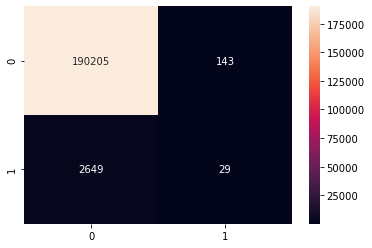

In [22]:
pred = log_pipe_scale.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [23]:
score_model('Logistic_regression', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Logistic_regression,0.010829,0.168605,0.015549


In [24]:
df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

df['actual'] = y_val
df.loc[(df[1] >=0.4), 'pred'] = 1 
df.loc[(df[1] <0.4), 'pred'] = 0 

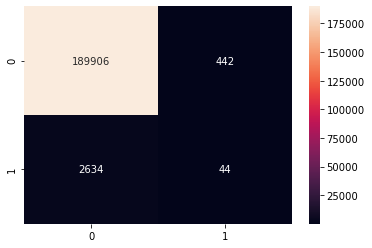

In [25]:
conf_matrix = confusion_matrix(df['actual'], df['pred'])

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [26]:
score_model('Logistic_regression', ['recall','precision','avg_precision'], 
            df['actual'], df['pred'])

,model,recall,precision,avg_precision
0,Logistic_regression,0.01643,0.090535,0.015133


In [27]:
eval_df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

eval_df['actual'] = y_val

def eval_threshold(eval_df, t_list):
    output_df = pd.DataFrame()
    avg_pre_list = []
    for threshold in t_list:
        eval_df.loc[(eval_df[1] >=threshold), 'pred'] = 1 
        eval_df.loc[(eval_df[1] <threshold), 'pred'] = 0 
        avg_pre_list.append(average_precision_score(eval_df['actual'], 
                                                    eval_df['pred']))
    output_df['threshold'] = t_list
    output_df['avg_precision'] = avg_pre_list
    return output_df
    
comp = eval_threshold(eval_df, list(np.arange(0,1,0.05)))
  
  

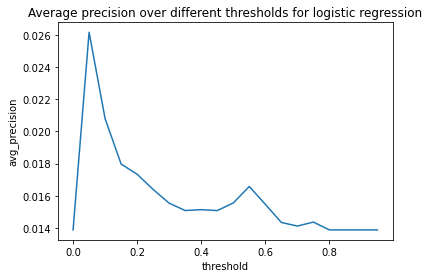

In [28]:
ax=sns.lineplot(comp['threshold'], comp['avg_precision'])
_=ax.set_title('Average precision over different thresholds for logistic regression')

In [29]:
param_grid = {'logisticregression__C': [0.1, 0.01, 0.5, 1],
             'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 
                                           'sag', 'saga']}
grid = GridSearchCV(log_pipe_scale, param_grid, cv=3, scoring = 'average_precision', n_jobs = 6)
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [30]:
X_train_transformed = preprocess_trans_scale.fit_transform(X_train)

d_train = lgb.Dataset(X_train_transformed, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

[LightGBM] [Info] Number of positive: 22337, number of negative: 1146349
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1168686, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019113 -> initscore=-3.938093
[LightGBM] [Info] Start training from score -3.938093


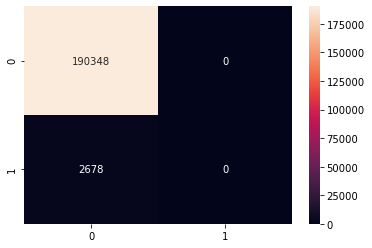

In [31]:
pred = clf.predict(preprocess_trans_scale.transform(X_val))
pred[pred <0.5] = 0
pred[pred >=0.5] = 1

conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [32]:
score_model('Light GBM', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Light GBM,0.0,0.0,0.013874


In [33]:
pred = clf.predict(preprocess_trans_scale.transform(X_val))


def eval_threshold(pred, y_val, t_list):
    output_df = pd.DataFrame()
    avg_pre_list = []
    for threshold in t_list:
        pred[pred <threshold] = 0
        pred[pred >=threshold] = 1
        avg_pre_list.append(average_precision_score(y_val, 
                                                    pred))
    
    
    
    
    
    
    output_df['threshold'] = t_list
    output_df['avg_precision'] = avg_pre_list
    return output_df
    
comp = eval_threshold(pred,y_val, list(np.arange(0,1,0.05)))
  
  

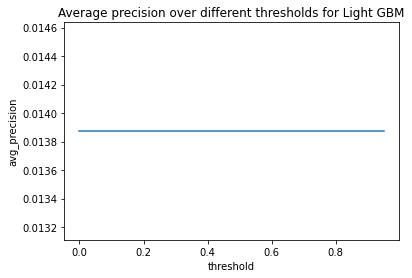

In [34]:
ax=sns.lineplot(comp['threshold'], comp['avg_precision'])
_=ax.set_title('Average precision over different thresholds for Light GBM')

In [35]:
train_0 = train[train['SepsisLabel'] ==0]
train_1 = train[train['SepsisLabel'] ==1]

filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train_0  = train_0[filtered_columns]
y_train_0 = train_0['SepsisLabel']

In [36]:
X_train_0_transformed = preprocess_trans_scale.fit_transform(X_train_0)

X_val_transformed = preprocess_trans_scale.transform(X_val)

In [37]:
X_train_0

,Gender,custom_hr,custom_temp,custom_age,custom_o2stat,custom_bp,custom_resp,ICULOS,HospAdmTime
0,0,Missing,Missing,old,Missing,Missing,Missing,1,-0.03
1,0,normal,Missing,old,normal,Missing,normal,2,-0.03
2,0,normal,Missing,old,normal,Missing,abnormal,3,-0.03
3,0,normal,Missing,old,normal,Missing,abnormal,4,-0.03
4,0,abnormal,Missing,old,abnormal,Missing,abnormal,5,-0.03
...,...,...,...,...,...,...,...,...,...
1168681,0,normal,Missing,child/adult,normal,Missing,normal,46,-5.07
1168682,0,normal,Missing,child/adult,normal,Missing,Missing,47,-5.07
1168683,0,normal,Missing,child/adult,normal,Missing,normal,48,-5.07
1168684,0,normal,Missing,child/adult,normal,Missing,normal,49,-5.07


In [38]:
y_train_0

0          0
1          0
2          0
3          0
4          0
          ..
1168681    0
1168682    0
1168683    0
1168684    0
1168685    0
Name: SepsisLabel, Length: 1146349, dtype: int64

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

nb_epoch = 200
batch_size = 128
input_dim = X_train_0_transformed.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [47]:
nb_epoch = 200
batch_size = 128
input_dim = X_train_0_transformed.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

encoder_input = keras.Input(shape=(input_dim, ))
x = layers.Dense(encoding_dim, activation="relu", activity_regularizer=tf.keras.regularizers.L1(learning_rate))(encoder_input)
x = layers.Dense(hidden_dim, activation="relu")(x)
x = layers.Dense(hidden_dim, activation="relu")(x)
x = layers.Dense(encoding_dim, activation="relu")(x)
encoder_output = layers.Dense(input_dim, activation="linear")(x)


autoencoder = keras.Model(encoder_input, encoder_output, name="encoder")
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                768       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_9 (Dense)              (None, 23)                759       
Total params: 2,871
Trainable params: 2,871
Non-trainable params: 0
_________________________________________________________

In [51]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = keras.callbacks.ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                              verbose=0)
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=25)
tb = keras.callbacks.TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(X_train_0_transformed, X_train_0_transformed,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1,
                    callbacks=[cp, tb, es]).history

Epoch 1/200
8956/8956 [==============================] - 5s 540us/step - loss: 0.0409 - accuracy: 0.1688
Epoch 2/200
8956/8956 [==============================] - 5s 529us/step - loss: 0.0027 - accuracy: 0.1981
Epoch 3/200
8956/8956 [==============================] - 5s 541us/step - loss: 0.0026 - accuracy: 0.1873
Epoch 4/200
8956/8956 [==============================] - 5s 538us/step - loss: 0.0026 - accuracy: 0.2186
Epoch 5/200
8956/8956 [==============================] - 5s 520us/step - loss: 0.0026 - accuracy: 0.2102
Epoch 6/200
8956/8956 [==============================] - 5s 517us/step - loss: 0.0026 - accuracy: 0.1996
Epoch 7/200
8956/8956 [==============================] - 5s 522us/step - loss: 0.0025 - accuracy: 0.2023
Epoch 8/200
8956/8956 [==============================] - 5s 521us/step - loss: 0.0025 - accuracy: 0.1992
Epoch 9/200
8956/8956 [==============================] - 5s 529us/step - loss: 0.0025 - accuracy: 0.1916
Epoch 10/200
8956/8956 [==============================]

8956/8956 [==============================] - 5s 520us/step - loss: 0.0017 - accuracy: 0.2291
Epoch 46/200
8956/8956 [==============================] - 5s 523us/step - loss: 0.0017 - accuracy: 0.2035
Epoch 47/200
8956/8956 [==============================] - 5s 533us/step - loss: 0.0017 - accuracy: 0.2024
Epoch 48/200
8956/8956 [==============================] - 5s 527us/step - loss: 0.0016 - accuracy: 0.2015
Epoch 49/200
8956/8956 [==============================] - 5s 537us/step - loss: 0.0011 - accuracy: 0.1629
Epoch 50/200
8956/8956 [==============================] - 5s 526us/step - loss: 0.0011 - accuracy: 0.1830
Epoch 51/200
8956/8956 [==============================] - 5s 521us/step - loss: 0.0011 - accuracy: 0.2009
Epoch 52/200
8956/8956 [==============================] - 5s 529us/step - loss: 0.0010 - accuracy: 0.2019
Epoch 53/200
8956/8956 [==============================] - 5s 526us/step - loss: 0.0010 - accuracy: 0.1854
Epoch 54/200
8956/8956 [==============================] - 5

Epoch 89/200
8956/8956 [==============================] - 5s 519us/step - loss: 7.1985e-04 - accuracy: 0.1916
Epoch 90/200
8956/8956 [==============================] - 5s 518us/step - loss: 7.5082e-04 - accuracy: 0.1858
Epoch 91/200
8956/8956 [==============================] - 5s 517us/step - loss: 7.2661e-04 - accuracy: 0.1975
Epoch 92/200
8956/8956 [==============================] - 5s 515us/step - loss: 7.6947e-04 - accuracy: 0.1945
Epoch 93/200
8956/8956 [==============================] - 5s 517us/step - loss: 7.1677e-04 - accuracy: 0.1854
Epoch 94/200
8956/8956 [==============================] - 5s 513us/step - loss: 7.2474e-04 - accuracy: 0.1879
Epoch 95/200
8956/8956 [==============================] - 5s 523us/step - loss: 7.3119e-04 - accuracy: 0.1861
Epoch 96/200
8956/8956 [==============================] - 5s 525us/step - loss: 7.2203e-04 - accuracy: 0.1893
Epoch 97/200
8956/8956 [==============================] - 5s 526us/step - loss: 7.5025e-04 - accuracy: 0.1860
Epoch 98/2

8956/8956 [==============================] - 5s 518us/step - loss: 6.4168e-04 - accuracy: 0.1792
Epoch 133/200
8956/8956 [==============================] - 5s 515us/step - loss: 6.2050e-04 - accuracy: 0.1779
Epoch 134/200
8956/8956 [==============================] - 5s 516us/step - loss: 5.9293e-04 - accuracy: 0.1848
Epoch 135/200
8956/8956 [==============================] - 5s 512us/step - loss: 6.7422e-04 - accuracy: 0.1595
Epoch 136/200
8956/8956 [==============================] - 5s 510us/step - loss: 6.4389e-04 - accuracy: 0.1675
Epoch 137/200
8956/8956 [==============================] - 5s 503us/step - loss: 6.4483e-04 - accuracy: 0.1690
Epoch 138/200
8956/8956 [==============================] - 5s 505us/step - loss: 6.0965e-04 - accuracy: 0.1724
Epoch 139/200
8956/8956 [==============================] - 4s 498us/step - loss: 6.6212e-04 - accuracy: 0.1664
Epoch 140/200
8956/8956 [==============================] - 4s 501us/step - loss: 6.6800e-04 - accuracy: 0.1765
Epoch 141/200
8

<AxesSubplot:>

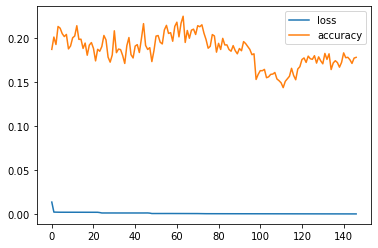

In [52]:
pd.DataFrame(history).plot()

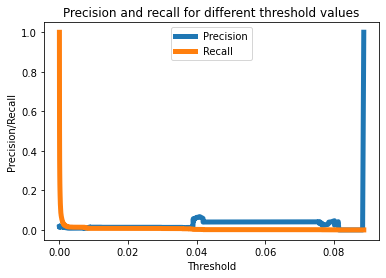

In [53]:
valid_x_predictions = autoencoder.predict(X_val_transformed)
mse = np.mean(np.power(X_val_transformed - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

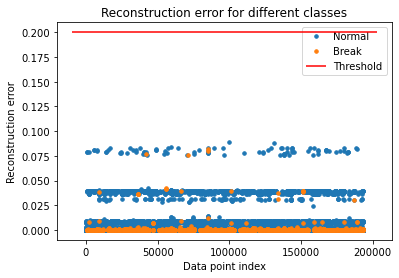

In [54]:
valid_x_predictions = autoencoder.predict(X_val_transformed)
mse = np.mean(np.power(X_val_transformed - valid_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.2
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

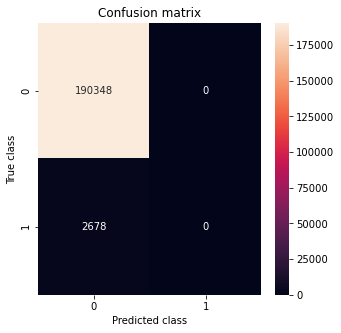

In [55]:
LABELS = ["Normal","Sepsis"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()